In [68]:
# 导入必要的库
import pandas as pd  # 用于数据处理和分析
import numpy as np  # 用于数值计算
import matplotlib.pyplot as plt  # 用于数据可视化
import seaborn as sns  # 用于高级数据可视化
import os  # 用于操作系统相关功能，如文件路径操作
import datetime  # 用于处理日期和时间
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler  # 用于数据预处理（标准化、编码等）
from sklearn.impute import SimpleImputer  # 用于处理缺失值
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score  # 用于数据集划分和交叉验证
from sklearn.metrics import roc_auc_score, roc_curve  # 用于评估模型性能（AUC指标）
import xgboost as xgb  # XGBoost模型库
import lightgbm as lgb  # LightGBM模型库
from catboost import CatBoostClassifier  # CatBoost模型库
from sklearn.linear_model import LogisticRegression  # 用于逻辑回归模型
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier  # 用于集成学习模型
import warnings  # 用于忽略警告信息
warnings.filterwarnings('ignore')  # 忽略所有警告信息

In [69]:
# 设置随机种子，保证结果可复现
np.random.seed(2025)

In [70]:
def reduce_mem_usage(df):#把数据类型转换为更小的类型
    """
    减少内存使用的函数
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('初始内存占用: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('优化后内存占用: {:.2f} MB'.format(end_mem))
    print('内存减少了 {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [71]:
# ===================== 数据集简易处理 ===================== #
# 数据读取
print('读取数据...')
train_data = pd.read_csv(r"train.csv")
test_data = pd.read_csv(r"testA.csv")
# 读取提交文件
if os.path.exists('submission.csv'):
    submission = pd.read_csv('submission.csv')
else:
    submission = pd.DataFrame({'id': test_data['id'], 'isDefault': 0})

# 减少训练集、测试集内存占用
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

# 显示数据集大小
print(f'训练集大小: {train_data.shape}')
print(f'测试集大小: {test_data.shape}')

# 合并数据集，方便同时进行数据处理
target = 'isDefault'  # 目标变量名 是否违约
train_target = train_data[target]
#保存id
train_id = train_data['id']
test_id = test_data['id']

# 删除ID列，因为id列仅用于标识，不参与建模，所以需要删除
train_data = train_data.drop(['id', target], axis=1)
test_data = test_data.drop(['id'], axis=1)

# 合并数据，便于后续处理
data_all = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

读取数据...
初始内存占用: 286.87 MB
优化后内存占用: 69.46 MB
内存减少了 75.8%
初始内存占用: 70.19 MB
优化后内存占用: 17.19 MB
内存减少了 75.5%
训练集大小: (800000, 47)
测试集大小: (200000, 46)


In [72]:
# ===================== 数据探索 ===================== #
print('进行数据探索...')

# 显示基本信息
print('数据基本信息:')
print(data_all.info())

# 数值型变量分析
numerical_fea = list(data_all.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea, list(data_all.columns)))
print(f'数值型特征数量: {len(numerical_fea)}')

# 类别型变量分析 上面那个是排除法，这个是包含法
# 这里将object和category类型的特征都视为类别型特征
category_fea = list(data_all.select_dtypes(include=['object', 'category']).columns)
print(f'类别型特征数量: {len(category_fea)}')

# 查看缺失值情况
missing_data = data_all.isnull().sum()
missing_cols = missing_data[missing_data > 0].index.tolist()
print(f'包含缺失值的列: {missing_cols}')
print(f'包含缺失值的列数量: {len(missing_cols)}')

进行数据探索...
数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 45 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   loanAmnt            1000000 non-null  float16 
 1   term                1000000 non-null  int8    
 2   interestRate        1000000 non-null  float16 
 3   installment         1000000 non-null  float16 
 4   grade               1000000 non-null  category
 5   subGrade            1000000 non-null  category
 6   employmentTitle     999999 non-null   float32 
 7   employmentLength    941459 non-null   category
 8   homeOwnership       1000000 non-null  int8    
 9   annualIncome        1000000 non-null  float32 
 10  verificationStatus  1000000 non-null  int8    
 11  issueDate           1000000 non-null  object  
 12  purpose             1000000 non-null  int8    
 13  postCode            999999 non-null   float16 
 14  regionCode          1000000 non-n

In [73]:
# ===================== 特征工程 ===================== #
print('进行特征工程...')

进行特征工程...


# 这个地方将连续变量离散化为5个离散变量，也许可以修改

In [74]:
# -------- 时间特征处理 --------
# 将issueDate转换为时间格式并提取更多时间特征
for data in [data_all]:
    # 转换时间格式，将字符串转换为日期时间对象
    data['issueDate'] = pd.to_datetime(data['issueDate'], format='%Y-%m-%d')
    
    # 提取基本时间特征，包括年、月、日、星期几、季度等
    data['issueDateYear'] = data['issueDate'].dt.year
    data['issueDateMonth'] = data['issueDate'].dt.month
    data['issueDateDay'] = data['issueDate'].dt.day
    data['issueDateWeekday'] = data['issueDate'].dt.weekday
    data['issueDateQuarter'] = data['issueDate'].dt.quarter
    
    # 计算相对日期（距离2007-06-01的天数）
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

# 处理earliesCreditLine特征，最早开通账户时间
data_all['earliesCreditLine'] = pd.to_datetime(data_all['earliesCreditLine'], format='%b-%Y', errors='coerce')

# 创建信用历史年龄特征，单位是月份
data_all['creditAge'] = (data_all['issueDate'].dt.year - data_all['earliesCreditLine'].dt.year) * 12 + \
                       (data_all['issueDate'].dt.month - data_all['earliesCreditLine'].dt.month)

# 提取earliesCreditLine的月份和年份作为特征
data_all['earliesCreditLineYear'] = data_all['earliesCreditLine'].dt.year
data_all['earliesCreditLineMonth'] = data_all['earliesCreditLine'].dt.month

# 计算信用年龄分类，分为五类，连续变量离散化
data_all['creditAgeBin'] = pd.qcut(data_all['creditAge'].clip(lower=0), 5, labels=False, duplicates='drop')

# 删除原始日期列，只保留处理后的特征
data_all.drop(['issueDate', 'earliesCreditLine'], axis=1, inplace=True)


In [75]:
# -------- 缺失值处理 --------

# 缺失值处理

# ====== 处理employmentLength特征 ======
# 步骤1：统一转换为字符串类型并处理缺失值

In [76]:
data_all['employmentLength'] = data_all['employmentLength'].astype(str)

# 步骤2：标准化字符串格式（处理所有可能的格式变化）

In [77]:
data_all['employmentLength'] = (
    data_all['employmentLength']
    .str.strip()       # 第一步：去除首尾空格
    .str.lower()       # 第二步：统一小写
    .replace({         # 第三步：替换不规则字符串
        '< 1 year': '0',         # 小于1年 → 0
        '10+ years': '10',       # 10年以上 → 10
        'nan': np.nan,           # 字符串 'nan' 转成实际的缺失值
        'n/a': np.nan,           # 表示空的、不可用的也设为缺失
        '': np.nan               # 空字符串也设为缺失
    })
)

In [78]:
# 步骤3：安全提取数值
def safe_extract(value):
    try:
        # 首先检查value是否为nan
        if pd.isna(value):
            return np.nan
            
        # 如果已经是数字类型，直接返回
        if isinstance(value, (int, float)):
            return value
            
        # 处理浮点型字符串（如"5.0"）
        if isinstance(value, str) and '.' in value:
            return float(value.split()[0])
            
        # 处理整数型字符串（如"5 years"）
        if isinstance(value, str):
            return int(value.split()[0])
            
        return np.nan
    except (ValueError, AttributeError, IndexError, TypeError):
        return np.nan

In [79]:

data_all['employmentLength'] = data_all['employmentLength'].apply(safe_extract)

# 这里填充缺失值的方法是不是可以考虑修改一下

In [80]:
# 步骤4：中位数填充缺失值
median_value = data_all['employmentLength'].median()
data_all['employmentLength'] = data_all['employmentLength'].fillna(median_value).astype(int)


In [81]:
# 步骤5：验证处理结果
print("employmentLength处理后取值分布:")
print(data_all['employmentLength'].value_counts(dropna=False))

employmentLength处理后取值分布:
employmentLength
10    328525
6     105123
2      90565
0      80226
3      80163
1      65671
5      62645
4      59818
8      45168
7      44230
9      37866
Name: count, dtype: int64


# 这里异常值处理和缺失值填充的方法是否可以修改呢

In [82]:
# 对数值型特征进行异常值处理和缺失值填充

#异常值处理，使用3sigma法则和分位数法
for col in numerical_fea:
    if col in data_all.columns:
        # 计算统计值用于异常值处理
        mean_val = data_all[col].mean()
        std_val = data_all[col].std()
        median_val = data_all[col].median()
        upper_limit = mean_val + 3 * std_val
        lower_limit = mean_val - 3 * std_val
        
        # 记录异常值比例
        outlier_ratio = ((data_all[col] > upper_limit) | (data_all[col] < lower_limit)).mean()
        print(f"列 {col} 的异常值比例: {outlier_ratio:.4f}")
        
        # 对异常值进行处理：使用分位数法
        if outlier_ratio > 0.01:  # 如果异常值比例大于1%
            q1 = data_all[col].quantile(0.25)
            q3 = data_all[col].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 1.5 * iqr
            lower_bound = q1 - 1.5 * iqr
            
            # 使用边界值替换异常值
            data_all.loc[data_all[col] > upper_bound, col] = upper_bound
            data_all.loc[data_all[col] < lower_bound, col] = lower_bound
            print(f"列 {col} 使用四分位法处理异常值")
        else:  # 如果异常值比例较小，使用3sigma法则
            # 对异常值进行替换
            data_all.loc[data_all[col] > upper_limit, col] = upper_limit
            data_all.loc[data_all[col] < lower_limit, col] = lower_limit
            print(f"列 {col} 使用3sigma法则处理异常值")
        
        # 缺失值填充，使用中位数填充
        data_all[col] = data_all[col].fillna(median_val)

列 loanAmnt 的异常值比例: 0.0000
列 loanAmnt 使用3sigma法则处理异常值
列 term 的异常值比例: 0.0000
列 term 使用3sigma法则处理异常值
列 interestRate 的异常值比例: 0.0000
列 interestRate 使用3sigma法则处理异常值
列 installment 的异常值比例: 0.0000
列 installment 使用3sigma法则处理异常值
列 employmentTitle 的异常值比例: 0.0000
列 employmentTitle 使用3sigma法则处理异常值
列 homeOwnership 的异常值比例: 0.0004
列 homeOwnership 使用3sigma法则处理异常值
列 annualIncome 的异常值比例: 0.0073
列 annualIncome 使用3sigma法则处理异常值
列 verificationStatus 的异常值比例: 0.0000
列 verificationStatus 使用3sigma法则处理异常值
列 purpose 的异常值比例: 0.0213
列 purpose 使用四分位法处理异常值
列 postCode 的异常值比例: 0.0000
列 postCode 使用3sigma法则处理异常值
列 regionCode 的异常值比例: 0.0000
列 regionCode 使用3sigma法则处理异常值
列 dti 的异常值比例: 0.0000
列 dti 使用3sigma法则处理异常值
列 delinquency_2years 的异常值比例: 0.0000
列 delinquency_2years 使用3sigma法则处理异常值
列 ficoRangeLow 的异常值比例: 0.0000
列 ficoRangeLow 使用3sigma法则处理异常值
列 ficoRangeHigh 的异常值比例: 0.0000
列 ficoRangeHigh 使用3sigma法则处理异常值
列 openAcc 的异常值比例: 0.0000
列 openAcc 使用3sigma法则处理异常值
列 pubRec 的异常值比例: 0.0000
列 pubRec 使用3sigma法则处理异常值
列 pubRecBankruptcies 

# 使用众数填充真的好吗

In [83]:
# 对类别型特征进行缺失值填充
for col in category_fea:
    if col in data_all.columns:
        # 使用众数填充
        mode_val = data_all[col].mode()[0]
        data_all[col] = data_all[col].fillna(mode_val)
        print(f"列 {col} 使用众数 {mode_val} 填充缺失值")

列 grade 使用众数 B 填充缺失值
列 subGrade 使用众数 C1 填充缺失值
列 employmentLength 使用众数 10 填充缺失值


# 这个编码方法没听说过，不知道好用不好用

In [84]:
# -------- 特征编码 --------
# 对类别型特征进行编码成数字，使用LabelEncoder，方便后续模型训练
for col in ['grade', 'subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'initialListStatus']:
    if col in data_all.columns:
        le = LabelEncoder()
        data_all[col] = le.fit_transform(data_all[col].astype(str))

这段代码是在进行非常重要的一步：**特征衍生与交互特征构造**。

通俗讲，它就是在“原始数据”基础上，**组合计算出新的特征变量**，以便让模型学到更多“潜在模式”，提高预测准确率。

---

我们来逐段解释：👇

---

## 🎯 **目的是什么？**

> **通过组合原始变量** → 构造出更具解释力的新变量（叫做“衍生特征”、“交互特征”）  
> 让模型更容易捕捉复杂的非线性关系，提高模型性能。

---

## 🔢 1~16：数学衍生特征

每一行都是计算新特征变量：

| 特征名 | 含义 | 建模价值 |
|--------|------|-----------|
| `debt_to_income` | `dti` 的拷贝 | 有时方便统一使用 |
| `debt_to_income_ratio` | 负债比 / 月收入 | 月还款压力 |
| `installment_income_ratio` | 月供 / 月收入 | 还款能力指标 |
| `installment_income_ratio_yearly` | 年供 / 年收入 | 另一种还款能力表示 |
| `loan_income_ratio` | 贷款金额 / 年收入 | 财务负担 |
| `historical_delinquency_rate` | 逾期次数 / 账户数 | 信用表现相对值 |
| `credit_utilization_ratio` | 已用额度 / 信用额度（+1防除0） | 信用卡使用比例 |
| `interest_to_grade` | 利率 / 等级 | 反映风险收益对应性 |
| `util_to_loan` | 信用额度利用率 × 贷款金额 | 复合风险特征 |
| `installment_to_loan` | 每月供款 / 总贷款 | 是否选择了高月供短期贷 |
| `term_to_interest` | 贷款期数 × 利率 | 总利息的线索 |
| `loan_to_term` | 总贷款 / 期数 | 每期平均额度 |
| `fico_to_interest` | 信用分 / 利率 | 是否与信用匹配 |
| `open_to_total_acc` | 开放账户 / 总账户 | 账户活跃度 |
| `fico_range_diff` | 最高分 - 最低分 | 信用分数波动情况 |
| `loan_to_fico` | 贷款 / 信用评分 | 是否贷款额度过高 |
| `acc_to_credit_age` | 账户数 / 信用龄 | 开户频率 |
| `loan_to_installment` | 总贷款 / 每月供款 | 贷款周期隐含特征 |

这些变量都能提供模型新的“角度”去观察违约风险。

---

## 🎯 17. **均值编码（Mean Encoding / Target Encoding）**

```python
for col in ['grade', 'subGrade', ...]:
    encoding_dict = train_with_target.groupby(col)['isDefault'].mean().to_dict()
    data_all[f'{col}_mean_target'] = data_all[col].map(encoding_dict)
```

- 逻辑：对于每个类别变量，计算该类别的平均违约率作为一个新的数值特征。
- 例如：
  - `grade = A` → 平均违约率为 0.05
  - `grade = G` → 平均违约率为 0.23
- **优势**：比 one-hot 编码更紧凑，保留了目标变量的信息

⚠️：此处是训练集 `train_with_target` 上提取均值，确保无数据泄露。

---

## 🌍 18. 与地区相关的统计特征

如果数据有地区（`regionCode`）：
- 计算该地区的平均违约率
- 计算该地区的平均贷款金额

这些特征揭示了地区经济水平或信用行为的差异。

---

## 🎯 19. 与贷款用途相关的统计特征

如果有贷款用途（`purpose`）：
- 每种用途的平均利率
- 每种用途的平均贷款金额
- 每种用途的平均违约率

有助于模型理解不同贷款动机的风险差异：
> 比如“买车”贷款比“债务整合”贷款更安全。

---

## ✅ 总结（人话版）

这段代码的本质是：
> 用数学计算、变量组合、分组统计等方法，**衍生出几十个新变量**，让模型不只是看“原始字段”，而是能学到“更深层的信息”。

| 特征类型 | 方法 | 意图 |
|----------|------|------|
| 数学比率 | 除法、乘法 | 转化为相对值，更具稳定性 |
| 交叉组合 | 变量相乘/相除 | 捕捉非线性关联 |
| 均值编码 | groupby + mean | 提供类别的目标值倾向 |
| 地区/用途统计 | 分组聚合 | 加入“群体行为”信号 |

---

如果你希望我：
- 可视化这些衍生特征的分布
- 检查这些特征和目标变量的相关性（信息增益、IV值、皮尔森系数）
- 封装一个函数批量做这些事

我可以直接帮你写 😎

In [85]:
# -------- 特征交互与衍生 --------
# 1. 负债收入比的衍生特征
data_all['debt_to_income'] = data_all['dti']
data_all['debt_to_income_ratio'] = data_all['dti'] / (data_all['annualIncome'] / 12)

# 2. 添加还款压力比例 (分期付款金额 / 年收入)
data_all['installment_income_ratio'] = data_all['installment'] / (data_all['annualIncome'] / 12)
data_all['installment_income_ratio_yearly'] = data_all['installment'] * 12 / data_all['annualIncome']

# 3. 添加贷款金额与年收入的比例
data_all['loan_income_ratio'] = data_all['loanAmnt'] / data_all['annualIncome']

# 4. 添加历史逾期率
data_all['historical_delinquency_rate'] = data_all['delinquency_2years'] / (data_all['openAcc'] + 1)

# 5. 添加信用卡使用率特征
data_all['credit_utilization_ratio'] = data_all['revolBal'] / (data_all['revolUtil'] + 1)

# 6. 贷款利率与等级的交互
data_all['interest_to_grade'] = data_all['interestRate'] / (data_all['grade'] + 1)

# 7. 额度利用率与贷款金额的交互
data_all['util_to_loan'] = data_all['revolUtil'] * data_all['loanAmnt'] / 10000

# 8. 分期付款与贷款金额的比率
data_all['installment_to_loan'] = data_all['installment'] / data_all['loanAmnt']

# 9. 贷款期限与利率的交互
data_all['term_to_interest'] = data_all['term'] * data_all['interestRate'] / 100

# 10. 贷款金额与期限的比率
data_all['loan_to_term'] = data_all['loanAmnt'] / data_all['term']

# 11. 信用评分与利率的交互
data_all['fico_to_interest'] = data_all['ficoRangeLow'] / data_all['interestRate']

# 12. 总账户数与开放账户数的比率
data_all['open_to_total_acc'] = data_all['openAcc'] / (data_all['totalAcc'] + 1)

# 13. 添加信用评分差异
data_all['fico_range_diff'] = data_all['ficoRangeHigh'] - data_all['ficoRangeLow']

# 14. 添加贷款额度与信用评分的交互
data_all['loan_to_fico'] = data_all['loanAmnt'] / data_all['ficoRangeLow']

# 15. 添加总账户数与信用年龄的比率
data_all['acc_to_credit_age'] = data_all['totalAcc'] / (data_all['creditAge'] + 1)

# 16. 添加贷款金额与分期付款金额的比率
data_all['loan_to_installment'] = data_all['loanAmnt'] / data_all['installment']

# 17. 添加均值编码特征
# 确保训练数据中有isDefault列
train_with_target = data_all[:len(train_data)].copy()
train_with_target['isDefault'] = train_target.values

for col in ['grade', 'subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'initialListStatus']:
    # 对训练集计算每个类别的目标均值
    if col in data_all.columns:
        encoding_dict = train_with_target.groupby(col)['isDefault'].mean().to_dict()
        data_all[f'{col}_mean_target'] = data_all[col].map(encoding_dict)

# 18. 添加与地区相关的统计特征
if 'regionCode' in data_all.columns:
    # 每个regionCode的违约率
    region_default = train_with_target.groupby('regionCode')['isDefault'].mean()
    data_all['region_default_rate'] = data_all['regionCode'].map(region_default)
    
    # 每个regionCode的平均贷款金额
    region_loan = data_all.groupby('regionCode')['loanAmnt'].mean()
    data_all['region_avg_loan'] = data_all['regionCode'].map(region_loan)

# 19. 添加贷款目的相关的统计特征
if 'purpose' in data_all.columns:
    # 每种目的的平均利率
    purpose_interest = data_all.groupby('purpose')['interestRate'].mean()
    data_all['purpose_avg_interest'] = data_all['purpose'].map(purpose_interest)
    
    # 每种目的的平均贷款金额
    purpose_loan = data_all.groupby('purpose')['loanAmnt'].mean()
    data_all['purpose_avg_loan'] = data_all['purpose'].map(purpose_loan)
    
    # 每种目的的违约率
    purpose_default = train_with_target.groupby('purpose')['isDefault'].mean()
    data_all['purpose_default_rate'] = data_all['purpose'].map(purpose_default)

# 计算特征值之间的相关系数，如果相关系数大，就移除一个

In [86]:
# ===================== 特征选择 ===================== #
# 移除高度相关特征

def correlation_selector(X, threshold=0.8):
    try:
        corr_matrix = X.corr().abs()
        # 确保使用numpy.triu正确创建三角矩阵掩码
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return to_drop
    except Exception as e:
        print(f"相关性分析失败: {str(e)}")
        # 如果失败，返回空列表
        return []


In [87]:
# 分离训练集和测试集
train = data_all[:len(train_data)]
test = data_all[len(train_data):]

In [88]:
# 检查高相关性特征
try:
    high_corr_features = correlation_selector(train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']), 0.90)
    print(f"高相关性特征数量: {len(high_corr_features)}")
    print(f"高相关性特征: {high_corr_features}")
    
    # 去除高相关性特征
    data_all = data_all.drop(high_corr_features, axis=1)
except Exception as e:
    print(f"去除高相关性特征失败: {str(e)}")
    # 不做任何删除

高相关性特征数量: 23
高相关性特征: ['installment', 'grade', 'subGrade', 'ficoRangeHigh', 'n3', 'n9', 'n10', 'issueDateQuarter', 'issueDateDT', 'earliesCreditLineYear', 'debt_to_income', 'installment_income_ratio_yearly', 'loan_income_ratio', 'historical_delinquency_rate', 'loan_to_term', 'loan_to_fico', 'loan_to_installment', 'grade_mean_target', 'subGrade_mean_target', 'verificationStatus_mean_target', 'initialListStatus_mean_target', 'purpose_avg_interest', 'purpose_default_rate']


In [89]:
# 重新分离训练集和测试集
train = data_all[:len(train_data)]
test = data_all[len(train_data):]

# 对于非树模型，将数据进行标准化，标准化为均值为0，方差为1的正态分布

In [90]:
# 标准化数值特征 (仅针对非树模型)
numeric_features_for_scaling = [col for col in numerical_fea if col in train.columns]
scaler = StandardScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[numeric_features_for_scaling] = scaler.fit_transform(train[numeric_features_for_scaling])
test_scaled[numeric_features_for_scaling] = scaler.transform(test[numeric_features_for_scaling])

In [91]:
# ===================== 模型训练与调参 ===================== #
print('='*80)
print('开始模型训练与调参...')
print('='*80)

开始模型训练与调参...


这段代码是在进行模型训练前的一项关键操作：**数据集划分 + 特征值预处理（处理异常值、无穷值、缺失值）**。我们来一块块拆解讲清楚。

---

## 🧩 第一部分：划分训练集和验证集
```python
X_train, X_val, y_train, y_val = train_test_split(
    train, train_target, test_size=0.2, random_state=42, stratify=train_target
)
```

### ✅ 作用
- 将你的训练数据（`train`）和目标标签（`train_target`）**划分为训练集和验证集**。
- `test_size=0.2` 表示 20% 的数据将作为验证集。
- `stratify=train_target` 表示使用**分层抽样**，保持训练集和验证集中类别分布一致（用于分类任务，防止类不平衡）。

---

## 🧩 第二部分：处理无穷大值和异常值

```python
for col in X_train.columns:
    ...
```

### 🧪 为什么这么做？

模型训练前必须确保数据**干净合理**：
- 没有 `inf`（无穷值）或 `nan`（空值）
- 没有极端异常值（比如特征值是 `1e20` 或 `-1e20` 这种极大极小数）
- 否则模型可能不收敛、预测不稳定，甚至直接报错

---

### 🧼 清洗步骤一：处理 `inf` 和 `-inf`
```python
X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
```
- 将所有正无穷和负无穷替换成 `np.nan`，为下一步的缺失值填充做准备。

---

### 🧼 清洗步骤二：处理异常大值
```python
upper_bound = X_train[col].quantile(0.99)
lower_bound = X_train[col].quantile(0.01)

if upper_bound > 1e8:
    X_train[col] = X_train[col].clip(upper=upper_bound)
```
- 计算第1% 和 第99% 分位数（即保留中间98%的数据）
- 如果第99%的值已经非常大（如大于1亿），说明该特征分布很偏，可能有极端异常值
- 用 `clip()` 限制最大值，不让极端值影响模型训练

---

### 🧼 清洗步骤三：填充缺失值
```python
X_train[col] = X_train[col].fillna(X_train[col].median())
```
- 对缺失值 `NaN` 进行填充
- 使用训练集的 **中位数**，这样在填充时不会泄露验证集或测试集的信息
- 保持数据分布稳定，适合大多数模型

---

## ✅ 总结作用：

| 步骤 | 操作 | 目的 |
|------|------|------|
| 1 | `train_test_split()` | 拆分训练集和验证集，确保泛化评估 |
| 2 | `replace([inf, -inf], NaN)` | 清除非法值 |
| 3 | `clip()` | 裁剪异常大值，防止模型受到极端干扰 |
| 4 | `fillna()` | 填充缺失值，避免训练时报错 |

---

这段代码是非常“工程实践化”的处理方式。模型能不能训好，很多时候就看这些 **干净数据预处理环节**做得细不细了。

---

如果你希望我把这个过程**封装成函数**、或**做成自动化预处理模块**，或者帮你接入 `Pipeline`，我也可以帮你写出来～要不要？

In [92]:
# 划分训练集和验证集
print('1. 划分训练集和验证集')
X_train, X_val, y_train, y_val = train_test_split(
    train, train_target, test_size=0.2, random_state=42, stratify=train_target
)
print(f'训练集大小: {X_train.shape}, 验证集大小: {X_val.shape}')

# 处理无穷大值和过大值
print('\n2. 处理无穷大值和异常值')
# 在模型训练前替换inf和极大值
for col in X_train.columns:
    # 替换无穷大值
    X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
    X_val[col] = X_val[col].replace([np.inf, -np.inf], np.nan)
    test[col] = test[col].replace([np.inf, -np.inf], np.nan)
    
    # 检查并替换极大或极小的值
    upper_bound = X_train[col].quantile(0.99)
    lower_bound = X_train[col].quantile(0.01)
    
    # 如果上限非常大，用更合理的值替代
    if upper_bound > 1e8:
        X_train[col] = X_train[col].clip(upper=upper_bound)
        X_val[col] = X_val[col].clip(upper=upper_bound)
        test[col] = test[col].clip(upper=upper_bound)
    
    # 填充缺失值
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_val[col] = X_val[col].fillna(X_train[col].median())
    test[col] = test[col].fillna(X_train[col].median())

print('数据预处理完成')


1. 划分训练集和验证集
训练集大小: (640000, 59), 验证集大小: (160000, 59)

2. 处理无穷大值和异常值
数据预处理完成


# 这段代码定义了一个用于评估二分类模型性能的函数，它的核心是计算 AUC 值（ROC曲线下面积），这是衡量模型分类效果的一种常用且稳定的指标，尤其适用于类别不平衡的情况。

In [93]:
# 定义评估函数
def model_evaluation(model, X, y):
    y_pred_prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred_prob)
    return auc


In [94]:
# 模型1: LightGBM
print('\n3. 训练LightGBM模型...')
print('-'*50)
lgb_params = {
    'objective': 'binary',              # 二分类任务
    'boosting_type': 'gbdt',            # 使用梯度提升树（默认）
    'metric': 'auc',                    # 使用 AUC 作为评估指标
    'n_estimators': 1000,               # 最多训练1000棵树（但会早停）
    'learning_rate': 0.05,              # 学习率（每棵树的权重缩小因子）
    'max_depth': 7,                     # 每棵树的最大深度
    'num_leaves': 31,                   # 每棵树的叶子节点数
    'subsample': 0.8,                   # 每棵树训练时使用80%的样本（防过拟合）
    'colsample_bytree': 0.8,            # 每棵树训练时使用80%的特征
    'min_child_weight': 5,              # 控制叶子节点的最小样本权重和（防过拟合）
    'min_child_samples': 30,            # 控制叶子节点的最小样本数
    'min_split_gain': 0.01,             # 控制分裂的最小增益
    'reg_alpha': 0.3,                   # L1 正则化
    'reg_lambda': 0.3,                  # L2 正则化
    'random_state': 42,                 # 固定随机种子，结果可复现
    'n_jobs': -1,                       # 使用所有CPU核心
    'verbosity': -1                     # 控制训练过程输出（-1表示静默）
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
# 最新的LightGBM版本中，早停参数通过callbacks参数传递
print('开始训练LightGBM模型...')
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100)]  # 不再使用verbose参数
)
print('LightGBM模型训练完成')


3. 训练LightGBM模型...
--------------------------------------------------
开始训练LightGBM模型...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's auc: 0.735691
LightGBM模型训练完成


In [95]:
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import roc_auc_score

# ===================== Optuna 调参目标函数 ===================== #
def objective(trial):
    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42,

        # 需要调参的部分 ↓↓↓
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
    }

    model = lgb.LGBMClassifier(**param, n_estimators=1000)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            LightGBMPruningCallback(trial, 'auc')
        ]
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc


# ===================== 开始调参 ===================== #
print('\n🚀 使用Optuna开始调参LightGBM...')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 可以调成更大的值，比如100

# ===================== 输出最优参数 ===================== #
print('\n🎯 Optuna调参完成！')
print('Best AUC:', study.best_value)
print('Best Hyperparameters:')
for k, v in study.best_params.items():
    print(f'  {k}: {v}')

# ===================== 用最优参数训练最终模型 ===================== #
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'verbosity': -1,
    'n_jobs': -1,
    'random_state': 42
})

print('\n🏁 使用最优参数重新训练LightGBM模型...')
final_lgbm_model = lgb.LGBMClassifier(**best_params, n_estimators=1000)
final_lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

print('✅ 最终模型训练完成！')


[I 2025-04-15 21:19:57,672] A new study created in memory with name: no-name-13b6daad-f1cd-4796-bf7c-0e21f4009c2c



🚀 使用Optuna开始调参LightGBM...
Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:20:02,983] Trial 0 finished with value: 0.7165399922830881 and parameters: {'learning_rate': 0.0017031439070567928, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 93, 'min_child_weight': 4.7507709370859335, 'subsample': 0.9392386756707851, 'colsample_bytree': 0.408248312517427, 'reg_alpha': 0.03577004231144713, 'reg_lambda': 0.013861710427355841, 'min_split_gain': 0.4129507061932446}. Best is trial 0 with value: 0.7165399922830881.


Early stopping, best iteration is:
[24]	valid_0's auc: 0.71654
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.73527


[I 2025-04-15 21:20:29,291] Trial 1 finished with value: 0.7352703686292037 and parameters: {'learning_rate': 0.04925539083910025, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 25, 'min_child_weight': 1.20305895094142, 'subsample': 0.7034553962700787, 'colsample_bytree': 0.7723858341601126, 'reg_alpha': 0.001761020804562959, 'reg_lambda': 0.004270650437107693, 'min_split_gain': 0.5896491629088436}. Best is trial 1 with value: 0.7352703686292037.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.712013


[I 2025-04-15 21:20:56,655] Trial 2 finished with value: 0.7120127124208862 and parameters: {'learning_rate': 0.0025384798912460745, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 41, 'min_child_weight': 3.123019391616099, 'subsample': 0.6117843785404178, 'colsample_bytree': 0.5009709700076532, 'reg_alpha': 0.023714912418445793, 'reg_lambda': 1.5251213406417203, 'min_split_gain': 0.16178594919127076}. Best is trial 1 with value: 0.7352703686292037.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's auc: 0.735834


[I 2025-04-15 21:21:23,728] Trial 3 finished with value: 0.7358336675573004 and parameters: {'learning_rate': 0.04349917508817114, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 12, 'min_child_weight': 0.013914085896640532, 'subsample': 0.4272822291217523, 'colsample_bytree': 0.5282906446753931, 'reg_alpha': 0.00184782592771305, 'reg_lambda': 0.016429400614128564, 'min_split_gain': 0.043118045136198324}. Best is trial 3 with value: 0.7358336675573004.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:21:28,276] Trial 4 finished with value: 0.733117329553107 and parameters: {'learning_rate': 0.23427031765456646, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 88, 'min_child_weight': 2.626270546359943, 'subsample': 0.7930266669748168, 'colsample_bytree': 0.7107869348833828, 'reg_alpha': 0.0031362568555826933, 'reg_lambda': 0.03071327610137785, 'min_split_gain': 0.44860725611708097}. Best is trial 3 with value: 0.7358336675573004.


Early stopping, best iteration is:
[60]	valid_0's auc: 0.733117


[I 2025-04-15 21:21:29,089] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:29,942] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:30,812] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:31,709] Trial 8 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's auc: 0.734666


[I 2025-04-15 21:21:42,264] Trial 9 finished with value: 0.7346657550978092 and parameters: {'learning_rate': 0.07845418157775196, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 43, 'min_child_weight': 0.001686334483108679, 'subsample': 0.967555900305187, 'colsample_bytree': 0.6466571747633436, 'reg_alpha': 0.00759657672501159, 'reg_lambda': 0.07034185104661038, 'min_split_gain': 0.08972257020445518}. Best is trial 3 with value: 0.7358336675573004.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.732235


[I 2025-04-15 21:21:47,255] Trial 10 finished with value: 0.732235382437441 and parameters: {'learning_rate': 0.22285387949959118, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 64, 'min_child_weight': 0.017925413027505513, 'subsample': 0.4026848760159921, 'colsample_bytree': 0.5638192193377669, 'reg_alpha': 0.2021280673152125, 'reg_lambda': 0.001004703698463974, 'min_split_gain': 0.3020652020290301}. Best is trial 3 with value: 0.7358336675573004.
[I 2025-04-15 21:21:48,117] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:49,018] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:49,891] Trial 13 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:21:55,269] Trial 14 pruned. Trial was pruned at iteration 74.
[I 2025-04-15 21:21:56,189] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:57,049] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:57,961] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:58,829] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:21:59,857] Trial 19 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:00,862] Trial 20 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's auc: 0.73464


[I 2025-04-15 21:22:10,830] Trial 21 finished with value: 0.7346404571033522 and parameters: {'learning_rate': 0.08569759801054834, 'num_leaves': 141, 'max_depth': 12, 'min_child_samples': 39, 'min_child_weight': 0.0020913771694108948, 'subsample': 0.99196902466155, 'colsample_bytree': 0.6376321419263474, 'reg_alpha': 0.00883493757794046, 'reg_lambda': 0.04458884283449809, 'min_split_gain': 0.11446921264501742}. Best is trial 3 with value: 0.7358336675573004.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.7336


[I 2025-04-15 21:22:18,106] Trial 22 finished with value: 0.7335997969973342 and parameters: {'learning_rate': 0.13241587772931684, 'num_leaves': 122, 'max_depth': 12, 'min_child_samples': 43, 'min_child_weight': 0.001007958469582591, 'subsample': 0.8524320295015175, 'colsample_bytree': 0.6093233905809211, 'reg_alpha': 0.0028687554010721115, 'reg_lambda': 0.24420582707036131, 'min_split_gain': 0.1509261868550354}. Best is trial 3 with value: 0.7358336675573004.
[I 2025-04-15 21:22:19,253] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:20,519] Trial 24 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:21,477] Trial 25 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:22,392] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:23,308] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:24,236] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:25,408] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:26,577] Trial 30 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.73467


[I 2025-04-15 21:22:38,113] Trial 31 finished with value: 0.7346702381535699 and parameters: {'learning_rate': 0.08167359649442191, 'num_leaves': 135, 'max_depth': 12, 'min_child_samples': 38, 'min_child_weight': 0.002215197955280905, 'subsample': 0.9838981255147466, 'colsample_bytree': 0.6083295569871157, 'reg_alpha': 0.009023598725930403, 'reg_lambda': 0.12745080885861435, 'min_split_gain': 0.11301375171705763}. Best is trial 3 with value: 0.7358336675573004.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:39,280] Trial 32 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.733894


[I 2025-04-15 21:22:45,240] Trial 33 finished with value: 0.7338939699849024 and parameters: {'learning_rate': 0.16154160651200325, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 41, 'min_child_weight': 0.0020402834552025453, 'subsample': 0.8921018632596649, 'colsample_bytree': 0.5091594553565657, 'reg_alpha': 0.004337644146880804, 'reg_lambda': 1.5847449047486155, 'min_split_gain': 0.1257664032258705}. Best is trial 3 with value: 0.7358336675573004.
[I 2025-04-15 21:22:46,279] Trial 34 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:47,500] Trial 35 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.734132


[I 2025-04-15 21:22:56,519] Trial 36 finished with value: 0.7341318016084779 and parameters: {'learning_rate': 0.09237056021038907, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 15, 'min_child_weight': 0.0017187263061868607, 'subsample': 0.9512444951664923, 'colsample_bytree': 0.6012176344206386, 'reg_alpha': 0.01850299376147343, 'reg_lambda': 0.12259632805988117, 'min_split_gain': 0.25568268163271485}. Best is trial 3 with value: 0.7358336675573004.
[I 2025-04-15 21:22:57,446] Trial 37 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:22:58,606] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:22:59,498] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:23:00,571] Trial 40 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.734787


[I 2025-04-15 21:23:10,886] Trial 41 finished with value: 0.7347866760430536 and parameters: {'learning_rate': 0.09199315760545437, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 37, 'min_child_weight': 0.002408483644795843, 'subsample': 0.9833703892001472, 'colsample_bytree': 0.6366416906248716, 'reg_alpha': 0.008727881489997424, 'reg_lambda': 0.03767419287322962, 'min_split_gain': 0.11721732763020229}. Best is trial 3 with value: 0.7358336675573004.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:23:15,300] Trial 42 pruned. Trial was pruned at iteration 69.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:23:23,154] Trial 43 pruned. Trial was pruned at iteration 134.
[I 2025-04-15 21:23:24,173] Trial 44 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:23:25,243] Trial 45 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds


[I 2025-04-15 21:23:26,173] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:23:27,093] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:23:27,998] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2025-04-15 21:23:28,998] Trial 49 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 50 rounds

🎯 Optuna调参完成！
Best AUC: 0.7358336675573004
Best Hyperparameters:
  learning_rate: 0.04349917508817114
  num_leaves: 48
  max_depth: 6
  min_child_samples: 12
  min_child_weight: 0.013914085896640532
  subsample: 0.4272822291217523
  colsample_bytree: 0.5282906446753931
  reg_alpha: 0.00184782592771305
  reg_lambda: 0.016429400614128564
  min_split_gain: 0.043118045136198324

🏁 使用最优参数重新训练LightGBM模型...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's auc: 0.735834
✅ 最终模型训练完成！


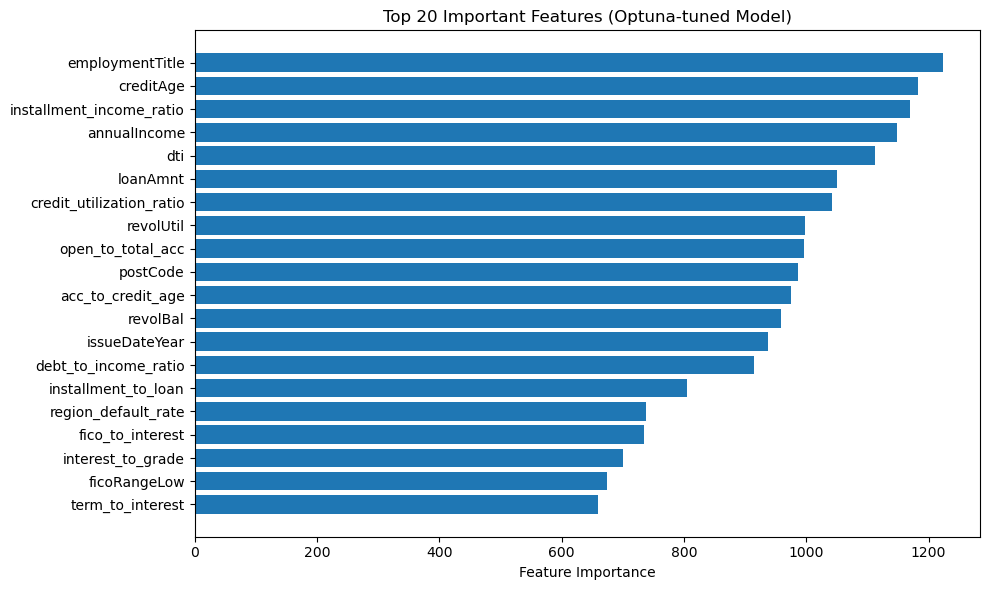

In [96]:
import matplotlib.pyplot as plt

top_features = lgb_importance.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features (Optuna-tuned Model)")
plt.tight_layout()
plt.show()


In [97]:
final_lgbm_auc = model_evaluation(final_lgbm_model, X_val, y_val)
print(f'✅ Optuna优化后的LightGBM验证集AUC: {final_lgbm_auc:.4f}')


✅ Optuna优化后的LightGBM验证集AUC: 0.7358


In [98]:
# 模型2: XGBoost
print('\n4. 训练XGBoost模型...')
print('-'*50)

xgb_params = {
    'objective': 'binary:logistic',      # 二分类任务，输出为概率
    'learning_rate': 0.05,               # 学习率，控制每棵树对最终结果的影响
    'max_depth': 6,                      # 决策树最大深度，限制模型复杂度
    'min_child_weight': 3,               # 子节点所需的最小样本权重和，控制过拟合
    'gamma': 0.1,                        # 分裂所需的最小损失下降，越大越保守
    'subsample': 0.8,                    # 每棵树训练时随机采样的样本比例
    'colsample_bytree': 0.8,             # 每棵树训练时随机采样的特征比例
    'scale_pos_weight': 1,               # 类别不平衡时的正类权重，1 表示样本均衡
    'reg_alpha': 0.1,                    # L1正则化项系数（控制特征选择）
    'reg_lambda': 0.1,                   # L2正则化项系数（防止权重过大）
    'n_estimators': 1000,                # 最多拟合的树数量（迭代次数上限）
    'random_state': 42,                  # 随机种子，保证结果可复现
    'n_jobs': -1,                        # 使用全部CPU核心进行训练
    'eval_metric': 'auc',               # 使用AUC作为评估指标
    'verbosity': 0,                      # 控制日志输出级别（0=只输出警告）
    'early_stopping_rounds': 100,        # 如果验证集AUC 100轮未提升，则提前停止
    'missing': np.nan                    # 指定缺失值的占位符（XGBoost自动处理）
}

xgb_model = xgb.XGBClassifier(**xgb_params)

print('开始训练XGBoost模型...')
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # 用训练集和验证集评估性能（训练集必须放前面以启用早停）
    verbose=100  # 每100轮打印一次训练进度
)

print('XGBoost模型训练完成')



4. 训练XGBoost模型...
--------------------------------------------------
开始训练XGBoost模型...
[0]	validation_0-auc:0.70339	validation_1-auc:0.70142
[100]	validation_0-auc:0.73731	validation_1-auc:0.72935
[200]	validation_0-auc:0.74709	validation_1-auc:0.73298
[300]	validation_0-auc:0.75424	validation_1-auc:0.73456
[400]	validation_0-auc:0.76014	validation_1-auc:0.73517
[500]	validation_0-auc:0.76547	validation_1-auc:0.73561
[600]	validation_0-auc:0.77059	validation_1-auc:0.73583
[700]	validation_0-auc:0.77547	validation_1-auc:0.73603
[800]	validation_0-auc:0.78013	validation_1-auc:0.73606
[857]	validation_0-auc:0.78270	validation_1-auc:0.73594
XGBoost模型训练完成


In [99]:
# 评估XGBoost模型
xgb_auc = model_evaluation(xgb_model, X_val, y_val)
print(f'XGBoost验证集AUC: {xgb_auc:.4f}')

XGBoost验证集AUC: 0.7361


In [100]:
# 模型3: CatBoost
print('\n5. 训练CatBoost模型...')
print('-'*50)
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.05,
    'depth': 6,
    'min_child_samples': 20,
    'l2_leaf_reg': 3,
    'random_strength': 0.1,
    'bagging_temperature': 1,
    'iterations': 1000,
    'random_seed': 42,
    'thread_count': -1,
    'verbose': 100  # 设置为100以每100次迭代显示一次进度
}

cat_model = CatBoostClassifier(**cat_params)
print('开始训练CatBoost模型...')
cat_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=100,  # 早停参数在fit方法中指定
    use_best_model=True,  # 确保使用最佳模型
    verbose=100  # 每100次迭代显示一次进度
)
print('CatBoost模型训练完成')



5. 训练CatBoost模型...
--------------------------------------------------
开始训练CatBoost模型...
0:	test: 0.6983230	best: 0.6983230 (0)	total: 231ms	remaining: 3m 51s
100:	test: 0.7255135	best: 0.7255135 (100)	total: 7.22s	remaining: 1m 4s
200:	test: 0.7300976	best: 0.7300976 (200)	total: 13.9s	remaining: 55.3s
300:	test: 0.7320580	best: 0.7320580 (300)	total: 20.4s	remaining: 47.5s
400:	test: 0.7332291	best: 0.7332291 (400)	total: 27.3s	remaining: 40.8s
500:	test: 0.7340301	best: 0.7340301 (500)	total: 34.3s	remaining: 34.1s
600:	test: 0.7346401	best: 0.7346401 (600)	total: 41s	remaining: 27.2s
700:	test: 0.7350226	best: 0.7350226 (700)	total: 47.6s	remaining: 20.3s
800:	test: 0.7354252	best: 0.7354288 (799)	total: 54.1s	remaining: 13.4s
900:	test: 0.7356365	best: 0.7356365 (900)	total: 1m	remaining: 6.63s
999:	test: 0.7358202	best: 0.7358311 (982)	total: 1m 6s	remaining: 0us

bestTest = 0.7358310536
bestIteration = 982

Shrink model to first 983 iterations.
CatBoost模型训练完成


In [101]:
# 评估CatBoost模型
cat_auc = model_evaluation(cat_model, X_val, y_val)
print(f'CatBoost验证集AUC: {cat_auc:.4f}')

CatBoost验证集AUC: 0.7358


In [102]:
# 模型4: 随机森林
print('\n6. 训练随机森林模型...')
print('-'*50)
rf_params = {
    'n_estimators': 200,
    'max_depth': 8,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1  # 显示训练进度
}

rf_model = RandomForestClassifier(**rf_params)
print('开始训练随机森林模型...')
rf_model.fit(X_train, y_train)
print('随机森林模型训练完成')



6. 训练随机森林模型...
--------------------------------------------------
开始训练随机森林模型...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   56.4s


随机森林模型训练完成


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished


In [103]:
# 评估随机森林模型
rf_auc = model_evaluation(rf_model, X_val, y_val)
print(f'随机森林验证集AUC: {rf_auc:.4f}')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


随机森林验证集AUC: 0.7150


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished


In [104]:
# ===================== 模型融合 ===================== #
print('\n='*80)
print('开始模型融合...')
print('='*80)

# 方法1: 简单平均
def simple_averaging(models, test):
    print('计算简单平均预测...')
    predictions = []
    for i, model in enumerate(models):
        pred = model.predict_proba(test)[:, 1]
        predictions.append(pred)
    return np.mean(np.array(predictions), axis=0)

# 方法2: 加权平均 (根据验证集上的性能加权)
def weighted_averaging(models, weights, test):
    print('计算加权平均预测...')
    predictions = []
    for i, model in enumerate(models):
        pred = model.predict_proba(test)[:, 1]
        predictions.append(pred * weights[i])
    return np.sum(np.array(predictions), axis=0) / np.sum(weights)

# 方法3: Stacking (使用5折交叉验证生成训练集的meta特征)
def stacking(base_models, meta_model, X, y, test, n_folds=5):
    print('执行Stacking集成...')
    # 生成元特征
    meta_features_train = np.zeros((X.shape[0], len(base_models)))
    meta_features_test = np.zeros((test.shape[0], len(base_models)))
    
    # K折交叉验证
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # 对每个基础模型
    for i, model in enumerate(base_models):
        print(f'处理第 {i+1}/{len(base_models)} 个基础模型...')
        # 对测试集的预测
        try:
            # XGBoost模型特殊处理 - 使用固定迭代次数而不使用早停
            if isinstance(model, xgb.XGBClassifier):
                print("  检测到XGBoost模型，使用固定迭代次数1000...")
                # 创建一个没有early_stopping的XGBoost模型副本
                xgb_clone = xgb.XGBClassifier(
                    objective='binary:logistic',
                    learning_rate=0.05,
                    max_depth=6,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=1,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    n_estimators=1000,  # 使用固定迭代次数1000
                    random_state=42,
                    n_jobs=-1,
                    verbosity=0
                )
                xgb_clone.fit(X, y)
                meta_features_test[:, i] = xgb_clone.predict_proba(test)[:, 1]
                
                # 对训练集进行交叉验证预测
                for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
                    print(f'  处理折 {fold+1}/{n_folds}')
                    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                    y_train_fold = y.iloc[train_index]
                    
                    xgb_clone.fit(X_train_fold, y_train_fold)
                    meta_features_train[val_index, i] = xgb_clone.predict_proba(X_val_fold)[:, 1]
            else:
                # 其他模型正常处理
                model.fit(X, y)
                meta_features_test[:, i] = model.predict_proba(test)[:, 1]
                
                # 对训练集进行交叉验证预测
                for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
                    print(f'  处理折 {fold+1}/{n_folds}')
                    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                    y_train_fold = y.iloc[train_index]
                    
                    model.fit(X_train_fold, y_train_fold)
                    meta_features_train[val_index, i] = model.predict_proba(X_val_fold)[:, 1]
        except Exception as e:
            print(f"模型 {i} 出现错误: {str(e)}")
            # 如果模型预测失败，使用该模型在验证集上的平均预测值填充
            meta_features_train[:, i] = y.mean()
            meta_features_test[:, i] = y.mean()
    
    # 训练元模型
    print('训练元模型...')
    meta_model.fit(meta_features_train, y)
    
    # 使用元模型预测测试集
    final_predictions = meta_model.predict_proba(meta_features_test)[:, 1]
    print('Stacking完成')
    
    return final_predictions


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
开始模型融合...


In [105]:
# 计算AUC
models = [final_lgbm_model, xgb_model, cat_model, rf_model]
val_aucs = [final_lgbm_auc, xgb_auc, cat_auc, rf_auc]
# 打印每个模型的AUC
print('\n各模型AUC:')
for model_name, auc in zip(['LightGBM', 'XGBoost', 'CatBoost', 'RandomForest'], val_aucs):
    print(f'{model_name} AUC: {auc:.4f}')


各模型AUC:
LightGBM AUC: 0.7358
XGBoost AUC: 0.7361
CatBoost AUC: 0.7358
RandomForest AUC: 0.7150


In [106]:
# 加权平均的权重 (根据模型在验证集上的表现)
weights = val_aucs.copy()

# 计算简单平均预测结果
try:
    simple_avg_pred = simple_averaging(models, test)
    print('简单平均预测完成')
except Exception as e:
    print(f"简单平均预测失败: {str(e)}")
    # 如果简单平均失败，使用表现最好的模型进行预测
    best_model_idx = val_aucs.index(max(val_aucs))
    simple_avg_pred = models[best_model_idx].predict_proba(test)[:, 1]
    print(f'使用最佳模型 ({["LightGBM", "XGBoost", "CatBoost", "RandomForest"][best_model_idx]}) 作为备选预测')

# 使用加权平均进行预测
try:
    weighted_pred = weighted_averaging(models, weights, test)
    print('加权平均预测完成')
except Exception as e:
    print(f"加权平均预测失败: {str(e)}")
    # 如果加权平均失败，使用简单平均的结果
    weighted_pred = simple_avg_pred
    print('使用简单平均结果作为备选预测')

# 使用Stacking进行预测
try:
    meta_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    stacking_pred = stacking(models, meta_model, X_train, y_train, test)
    print('Stacking预测完成')
except Exception as e:
    print(f"Stacking预测失败: {str(e)}")
    # 如果Stacking失败，使用加权平均的结果
    stacking_pred = weighted_pred
    print('使用加权平均结果作为备选预测')

# 最终融合策略 (加权平均多种融合方法)
try:
    print('\n组合所有预测方法...')
    final_pred = 0.20 * simple_avg_pred + 0.35 * weighted_pred + 0.45 * stacking_pred
    print('最终预测组合完成')
except Exception as e:
    print(f"最终融合失败: {str(e)}")
    # 如果最终融合失败，使用表现最好的融合方法结果
    if max(val_aucs) == val_aucs[0]:  # LightGBM是最好的模型
        final_pred = final_lgbm_model.predict_proba(test)[:, 1]
        print('使用LightGBM模型结果作为最终预测')
    elif max(val_aucs) == val_aucs[1]:  # XGBoost是最好的模型
        final_pred = xgb_model.predict_proba(test)[:, 1]
        print('使用XGBoost模型结果作为最终预测')
    elif max(val_aucs) == val_aucs[2]:  # CatBoost是最好的模型
        final_pred = cat_model.predict_proba(test)[:, 1]
        print('使用CatBoost模型结果作为最终预测')
    else:  # RandomForest是最好的模型
        final_pred = rf_model.predict_proba(test)[:, 1]
        print('使用RandomForest模型结果作为最终预测')

计算简单平均预测...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.5s finished


简单平均预测完成
计算加权平均预测...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished


加权平均预测完成
执行Stacking集成...
处理第 1/4 个基础模型...
  处理折 1/5
  处理折 2/5
  处理折 3/5
  处理折 4/5
  处理折 5/5
处理第 2/4 个基础模型...
  检测到XGBoost模型，使用固定迭代次数1000...
  处理折 1/5
  处理折 2/5
  处理折 3/5
  处理折 4/5
  处理折 5/5
处理第 3/4 个基础模型...
0:	total: 69.9ms	remaining: 1m 9s
100:	total: 5.97s	remaining: 53.1s
200:	total: 11.7s	remaining: 46.4s
300:	total: 17.4s	remaining: 40.3s
400:	total: 23s	remaining: 34.3s
500:	total: 28.7s	remaining: 28.6s
600:	total: 34.3s	remaining: 22.8s
700:	total: 40s	remaining: 17.1s
800:	total: 45.8s	remaining: 11.4s
900:	total: 51.4s	remaining: 5.65s
999:	total: 57.3s	remaining: 0us
  处理折 1/5
0:	total: 49.6ms	remaining: 49.5s
100:	total: 4.74s	remaining: 42.2s
200:	total: 9.24s	remaining: 36.7s
300:	total: 14s	remaining: 32.4s
400:	total: 18.5s	remaining: 27.6s
500:	total: 23.1s	remaining: 23s
600:	total: 27.7s	remaining: 18.4s
700:	total: 32.2s	remaining: 13.7s
800:	total: 36.6s	remaining: 9.1s
900:	total: 41.2s	remaining: 4.52s
999:	total: 45.9s	remaining: 0us
  处理折 2/5
0:	total: 52.6ms	r

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.5s finished


  处理折 1/5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   46.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


  处理折 2/5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   46.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.2s finished


  处理折 3/5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


  处理折 4/5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   46.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


  处理折 5/5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   45.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished


训练元模型...
Stacking完成
Stacking预测完成

组合所有预测方法...
最终预测组合完成


In [107]:
# ===================== 生成提交文件 ===================== #
print('\n='*80)
print('生成提交文件...')
print('='*80)
submission['isDefault'] = final_pred
submission.to_csv('submission_final.csv', index=False)

print('\n提交文件已生成!')
print(f"提交文件保存路径: {os.path.abspath('submission_final.csv')}")
# 打印各种融合方法的权重
print(f'简单平均权重: 0.20, 加权平均权重: 0.35, Stacking权重: 0.45')
print('最终融合策略: 0.20 * 简单平均 + 0.35 * 加权平均 + 0.45 * Stacking')


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
生成提交文件...

提交文件已生成!
提交文件保存路径: c:\Users\16050\Desktop\DataMining\submission_final.csv
简单平均权重: 0.20, 加权平均权重: 0.35, Stacking权重: 0.45
最终融合策略: 0.20 * 简单平均 + 0.35 * 加权平均 + 0.45 * Stacking
